In [1]:
import os
import mpbn
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

work_dir = '/home/spankaew/Git/BooleanBenchmark/'
project = 'Invasion'
model_dir = work_dir + 'models/' + project + '/'
#output_dir = work_dir + 'models/tmp/' + project + '/'

In [2]:
def clause_string(logic):
    logic_rules = []
    for i in range(len(logic)):
        logic_clause = logic[i].copy()
        formatted_strings = [f"{t[0]}" if t[1] else f"!{t[0]}" for t in logic_clause]
        single_line_string = ' & '.join(formatted_strings)
        logic_rules.append(single_line_string)
    return(logic_rules)

def dataframe_model_dnf(model_dnf):
    node_names = list(model_dnf.keys())
    logic_mtx = pd.DataFrame()
    for i in node_names:
        logic_mtx = pd.concat([logic_mtx,pd.DataFrame(clause_string(model_dnf[i]))], 
                        axis = 1, ignore_index = False,)
    logic_mtx = logic_mtx.applymap(lambda x: f"({x})" if isinstance(x, str) else x)    
    logic_mtx=logic_mtx.transpose()
    logic_mtx = logic_mtx.fillna('')
    logic_mtx.index = node_names
    logic_full = logic_mtx.agg(' | '.join, axis=1).str.strip(' | ')
    return(logic_full)

In [3]:
import os 
from tqdm import tqdm
model_files = os.listdir(model_dir)
model_logic = pd.DataFrame()

for i in tqdm(model_files):
    # Load file
    model = mpbn.load(model_dir + i)
    # Convert to dnf and dnf string
    model = model.as_dnf()
    model = dataframe_model_dnf(model)
    model.name = i.split('.')[0]
    # Concatenate to matrix
    model_logic = pd.concat([model_logic, model], axis = 1, ignore_index = False)

100%|██████████| 1025/1025 [03:54<00:00,  4.36it/s]


In [4]:
model_cluster = pd.read_csv(work_dir + 'tmp/Invasion_model_clusters.csv', index_col = 0)
model_cluster = model_cluster.sort_values('cluster')
model_cluster

,cluster
Invasion_558,0
Invasion_592,0
Invasion_591,0
Invasion_590,0
Invasion_589,0
...,...
Invasion_143,5
Invasion_138,5
Invasion_491,5
Invasion_312,5


In [5]:
var_logic_clust = pd.DataFrame()
for i in list(model_cluster.cluster.unique()):
    model_logic_sub = model_logic.transpose().loc[list(model_cluster.index[model_cluster.cluster == i])]
    #model_logic_sub = model_logic_sub.drop(['logic_cluster'], axis = 1)
    var_logic_length = []
    for j in model_logic_sub.columns:
        num_logic = model_logic_sub[j].value_counts().size
        var_logic_length.append(num_logic)
    var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = model_logic_sub.columns)
    var_logic_clust = pd.concat([var_logic_clust, var_logic_length], axis = 1, ignore_index = False)
var_logic_clust.columns = list(model_cluster.cluster.unique())

In [6]:
model_logic_t= model_logic.transpose()

# Ordinal encoding
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(model_logic_t)
encoded_df = pd.DataFrame(encoded_data, columns=model_logic_t.columns)

sort_index = encoded_df.max().sort_values().index
var_logic_clust= var_logic_clust.loc[sort_index]

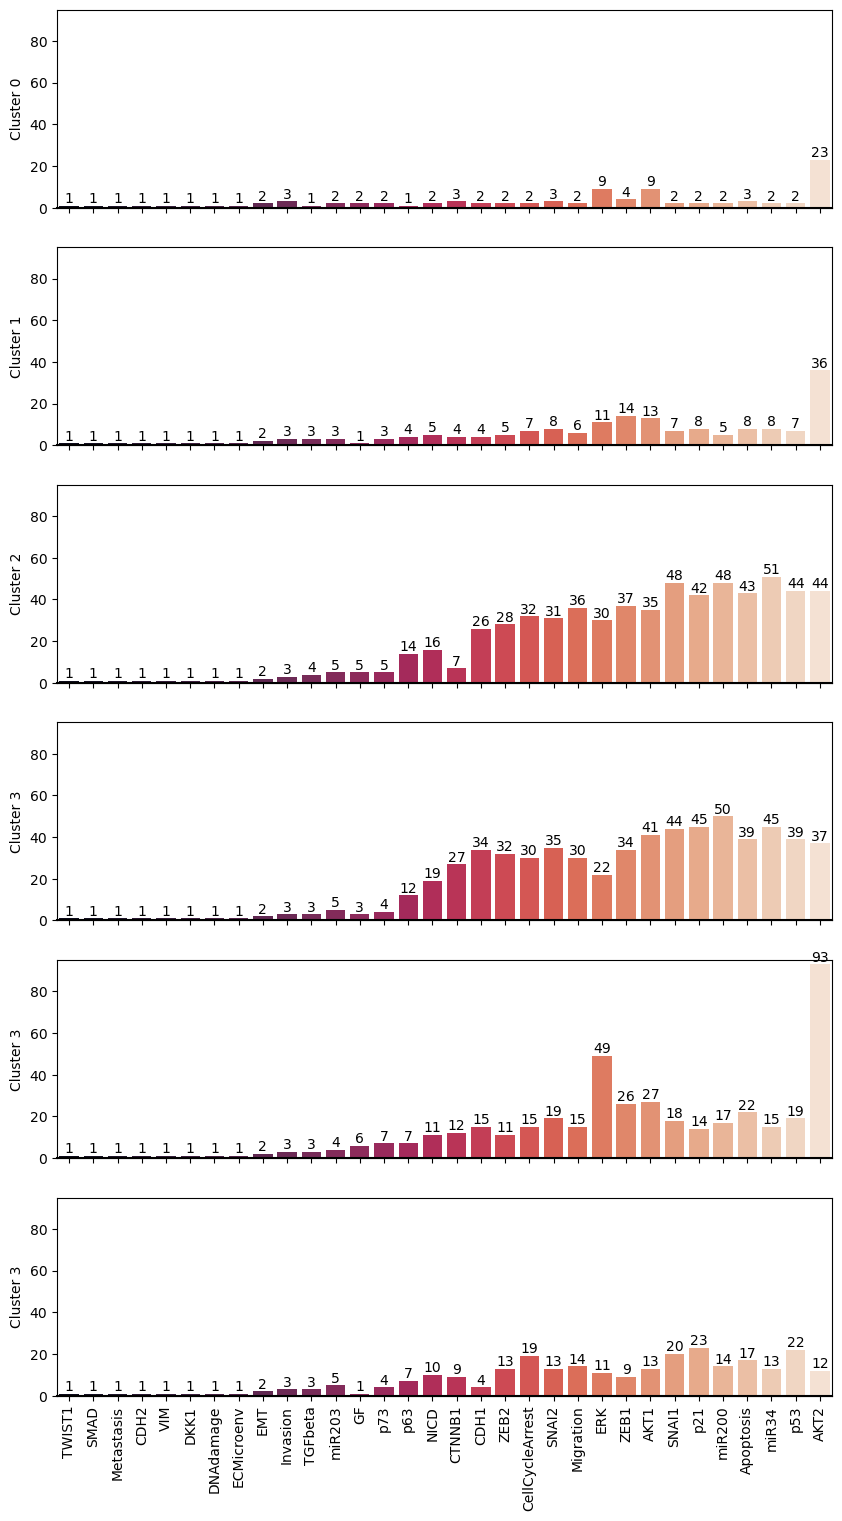

In [7]:
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(10, 18), sharex=True)
plt.ylim(0,65)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[0], palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Cluster 0")
ax1.bar_label(ax1.containers[0], fontsize=10)
ax1.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[1], palette="rocket", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Cluster 1")
ax2.bar_label(ax2.containers[0], fontsize=10)
ax2.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[2], palette="rocket", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Cluster 2")
ax3.bar_label(ax3.containers[0], fontsize=10)
ax3.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[3], palette="rocket", ax=ax4)
ax4.axhline(0, color="k", clip_on=False)
ax4.set_ylabel("Cluster 3")
ax4.bar_label(ax4.containers[0], fontsize=10)
ax4.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[4], palette="rocket", ax=ax5)
ax5.axhline(0, color="k", clip_on=False)
ax5.set_ylabel("Cluster 3")
ax5.bar_label(ax5.containers[0], fontsize=10)
ax5.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[5], palette="rocket", ax=ax6)
ax6.axhline(0, color="k", clip_on=False)
ax6.set_ylabel("Cluster 3")
ax6.bar_label(ax6.containers[0], fontsize=10)
ax6.set_ylim(0,95)


plt.xticks(rotation = 90)
plt.show()

In [9]:
from collections import Counter
# Function to count strings in a row
def count_strings_in_row(row):
    return Counter(row)

def split_gene_clauses(model_logic_mtx, gene): 
    split_data = [item.split(" | ") for item in model_logic_mtx.loc[gene]]
    df = pd.DataFrame(split_data, index = model_logic_mtx.loc[gene].index)
    return(df)

In [10]:
df = split_gene_clauses(model_logic, 'AKT2')
df = df.fillna(0)

from collections import Counter
# Function to count strings in a row
def count_strings_in_row(row):
    return Counter(row)

# Apply the function to each row and convert the result to a DataFrame
row_counts = df.apply(lambda row: pd.Series(count_strings_in_row(row)), 
                            axis=1).fillna(0)
logic_clause2 = row_counts.sum()/len(df)

In [11]:
def logic_clause_frequency(model_logic_mtx):
    logic_clause = pd.DataFrame()
    for i in model_logic_mtx.index:
        df = split_gene_clauses(model_logic_mtx, i)
        df = df.fillna(0)

        from collections import Counter
        # Function to count strings in a row
        def count_strings_in_row(row):
            return Counter(row)

        # Apply the function to each row and convert the result to a DataFrame
        row_counts = df.apply(lambda row: pd.Series(count_strings_in_row(row)), 
                                    axis=1).fillna(0)
        clauses = row_counts.sum()/len(df)
        logic_clause = pd.concat([logic_clause,clauses], ignore_index = True, axis = 1)
    logic_clause= logic_clause.fillna(0)
    logic_clause.columns = model_logic_mtx.index
    return(logic_clause)

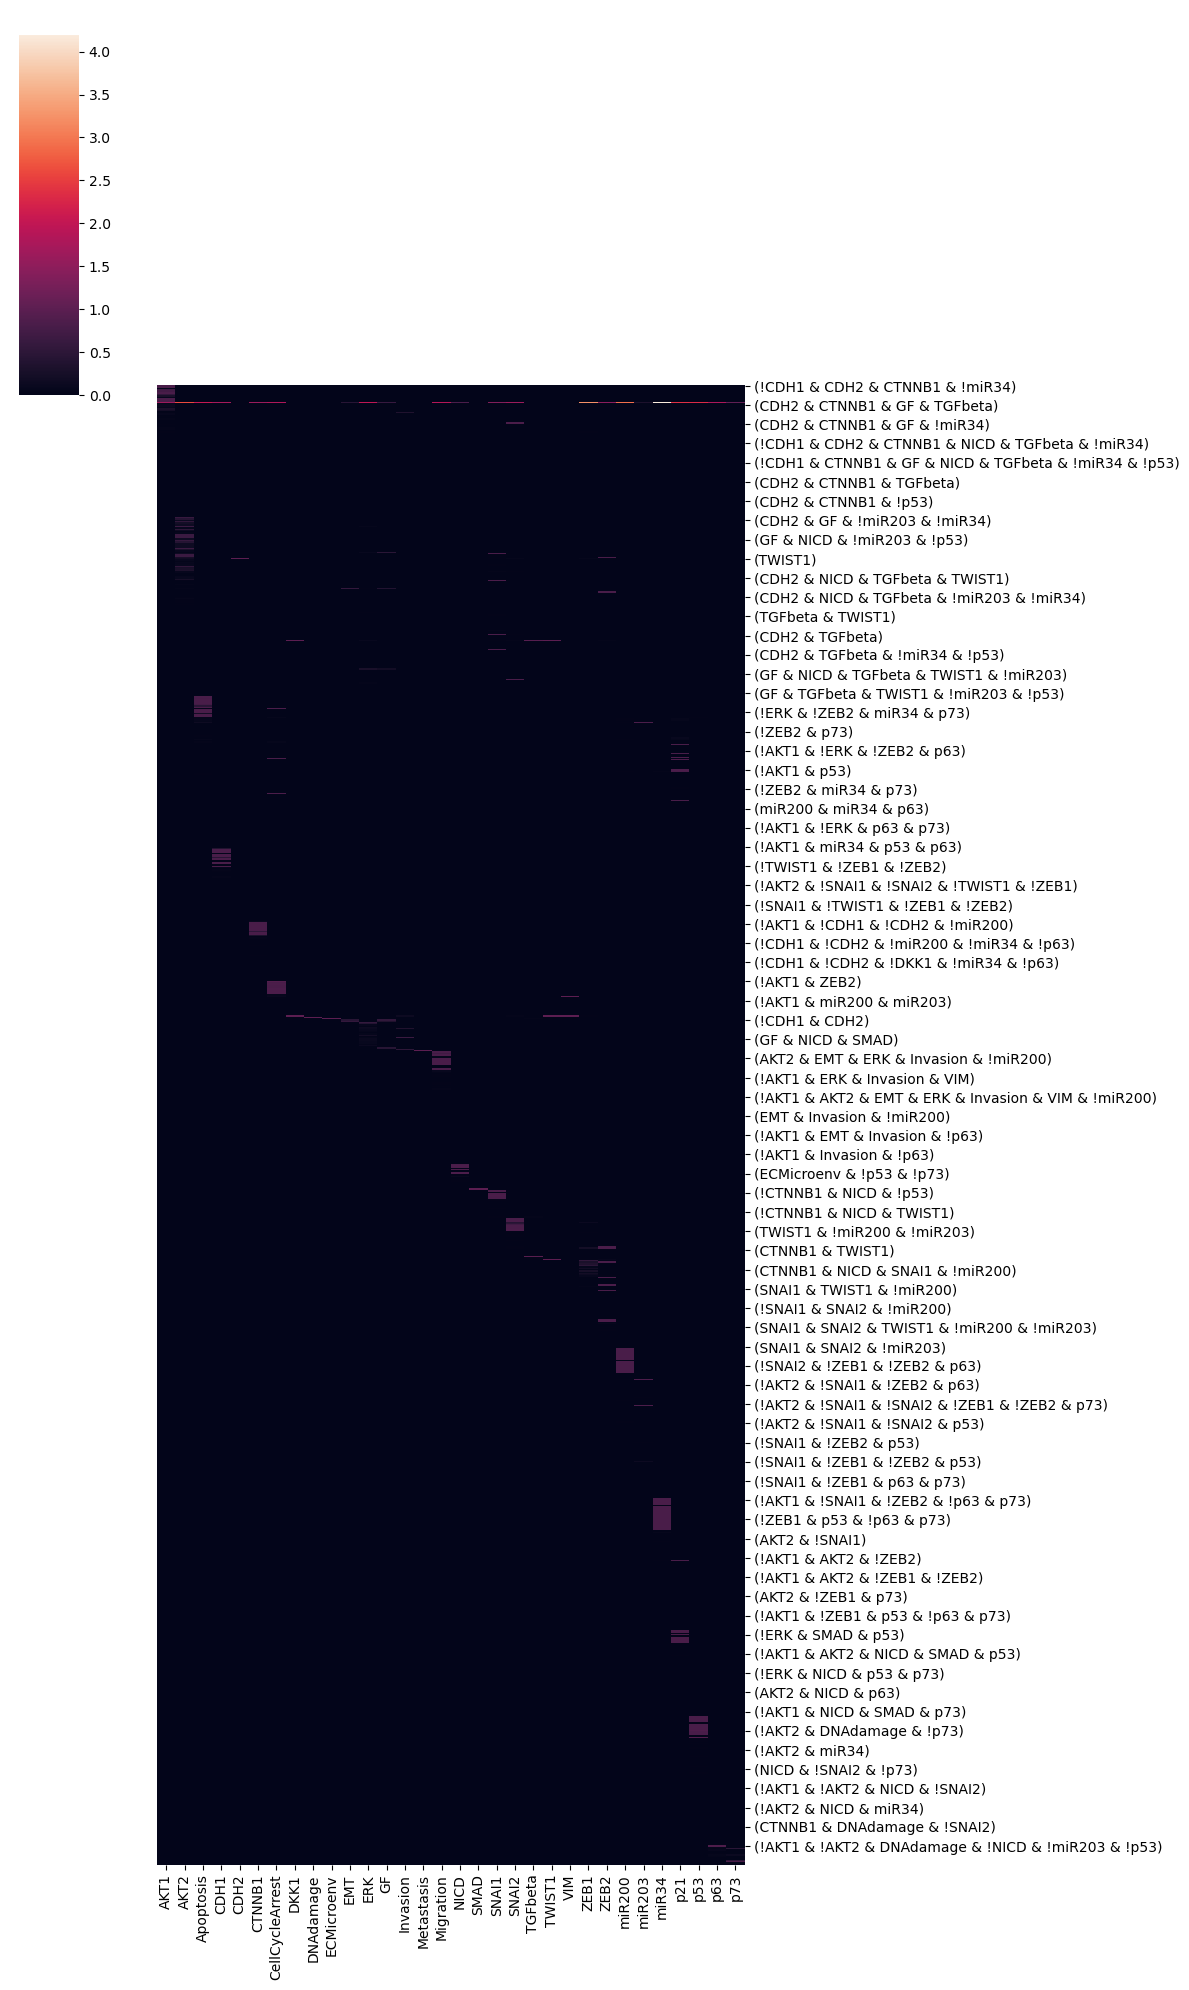

In [13]:
logic_cluase = logic_clause_frequency(model_logic)
sns.clustermap(logic_cluase, col_cluster = False, row_cluster = False, figsize = (12,20))
plt.show()

In [15]:
clause_0 = logic_clause_frequency(model_logic[model_cluster.index[model_cluster.cluster == 0]])
clause_1 = logic_clause_frequency(model_logic[model_cluster.index[model_cluster.cluster == 1]])
clause_2 = logic_clause_frequency(model_logic[model_cluster.index[model_cluster.cluster == 2]])
clause_3 = logic_clause_frequency(model_logic[model_cluster.index[model_cluster.cluster == 3]])
clause_4 = logic_clause_frequency(model_logic[model_cluster.index[model_cluster.cluster == 4]])
clause_5 = logic_clause_frequency(model_logic[model_cluster.index[model_cluster.cluster == 5]])

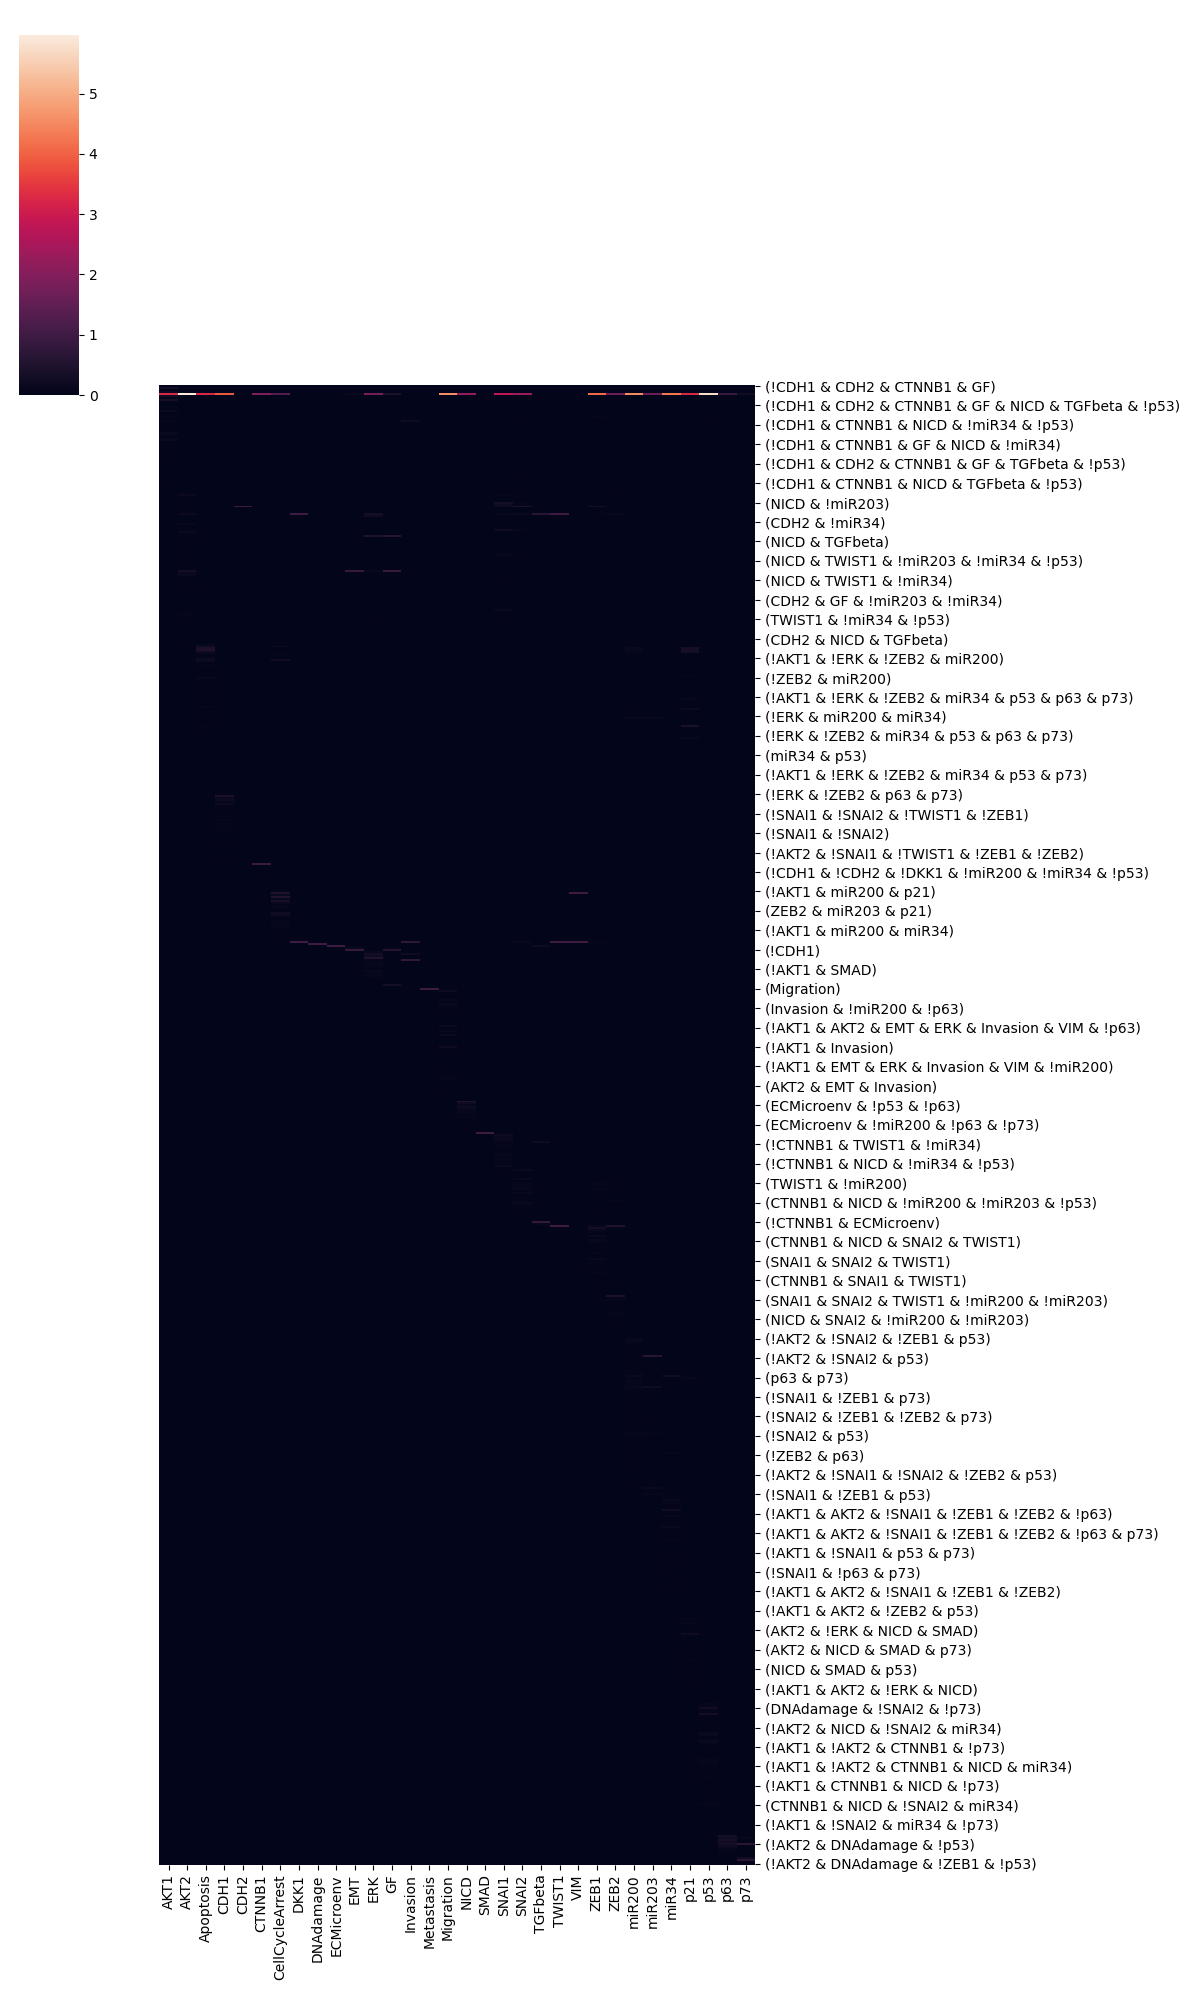

In [30]:
sns.clustermap(clause_2, col_cluster = False, row_cluster = False, figsize = (12,20))
plt.show()

In [18]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Sample DataFrame
logic_clause = logic_clause_frequency(model_logic[model_cluster.index[model_cluster.cluster == 0]])
logic_clause = logic_clause[sort_index]
data = logic_clause.transpose()
df = pd.DataFrame(data)

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on DataFrame
for level in range(len(df.index) - 1):
    for col in df.columns:
        parent = (level, col)
        child_level = level + 1
        for child_col in df.columns:
            child = (child_level, child_col)
            # Add edge with weight as the activity level of the child node
            G.add_edge(parent, child, weight=df.loc[df.index[child_level], child_col])

# Add node attributes for activity level
for level in range(len(df.index)):
    for col in df.columns:
        node = (level, col)
        G.nodes[node]['activity'] = df.loc[df.index[level], col]

# Identify nodes with activity level of 0
nodes_to_remove = [node for node in G.nodes if G.nodes[node]['activity'] == 0]

# Remove these nodes and their associated edges
G.remove_nodes_from(nodes_to_remove)

# Position nodes in a grid layout
pos = {}
for level in range(len(df.index)):
    for i, col in enumerate(df.columns):
        pos[(level, col)] = (i, -level)

# Draw the network
plt.figure(figsize=(14, 14))

# Draw the nodes with sizes proportional to activity levels
node_sizes = [G.nodes[node]['activity'] * 300 for node in G.nodes]
nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color=node_sizes, font_weight='bold', node_shape='o')

# Draw the edges
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=10, edge_color='gray')

# Draw the edge labels with weights
#edge_labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Set grid
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set title
plt.title('Hierarchical Network with Grid Layout')

plt.show()

KeyboardInterrupt: 

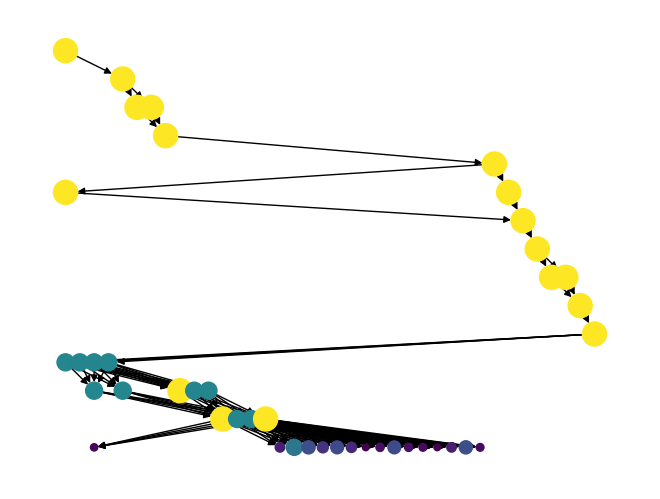

In [259]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Sample DataFrame
logic_clause = logic_clause[sort_index]
data = logic_clause.transpose()

df = pd.DataFrame(data)

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on DataFrame
for level in range(len(df.index) - 1):
    for col in df.columns:
        parent = (level, col)
        child_level = level + 1
        for child_col in df.columns:
            child = (child_level, child_col)
            # Add edge with weight as the activity level of the child node
            G.add_edge(parent, child, weight=df.loc[df.index[child_level], child_col])

# Add node attributes for activity level
for level in range(len(df.index)):
    for col in df.columns:
        node = (level, col)
        G.nodes[node]['activity'] = df.loc[df.index[level], col]

# Identify nodes with activity level of 0
nodes_to_remove = [node for node in G.nodes if G.nodes[node]['activity'] == 0]

# Remove these nodes and their associated edges
G.remove_nodes_from(nodes_to_remove)

# Position the nodes in a hierarchical layout
pos = {}
for level in range(len(df.index)):
    for i, col in enumerate(df.columns):
        pos[(level, col)] = (i, -level)

# Draw the nodes with sizes proportional to activity levels
node_sizes = [G.nodes[node]['activity'] * 300 for node in G.nodes]
nx.draw(G, pos, with_labels=False, 
        node_size=node_sizes, 
        node_color=node_sizes, 
        font_weight='bold')

# Draw the edge labels with weights
#edge_labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Set grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

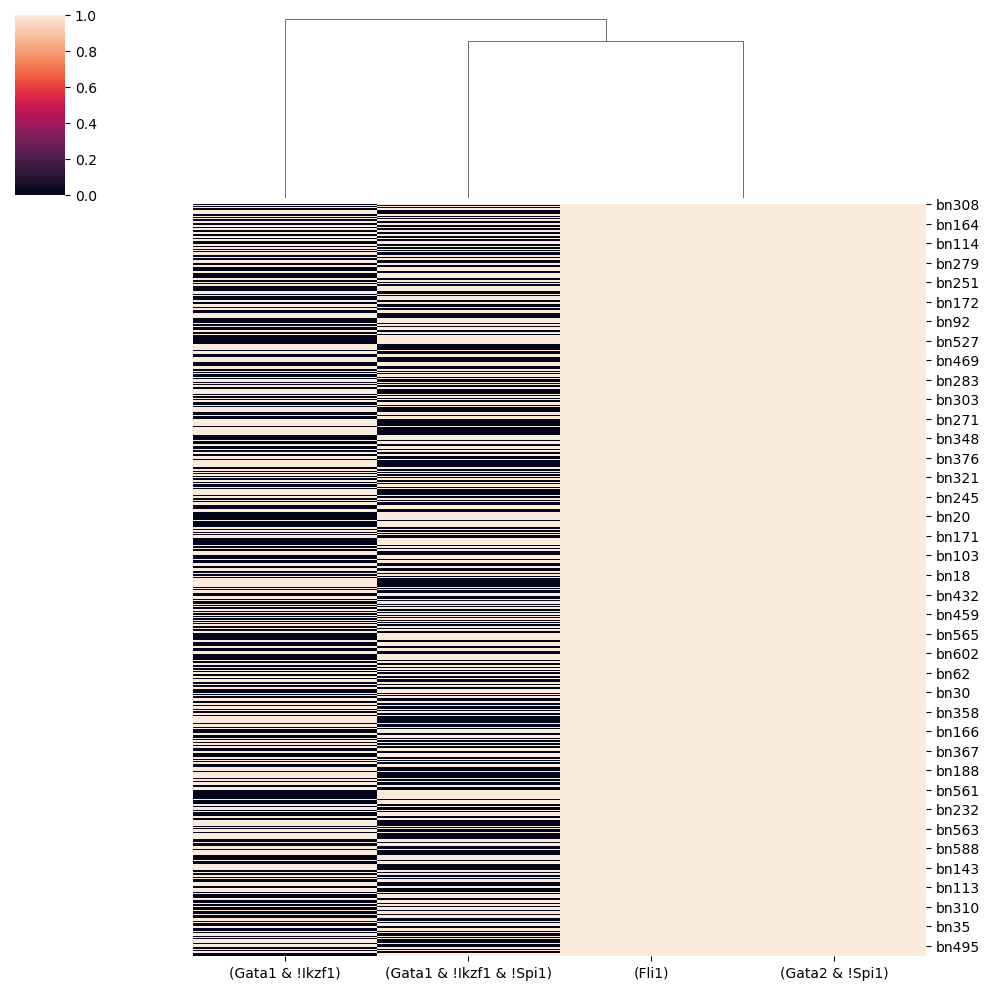

In [197]:
df = split_gene_clauses(model_logic, 'Gata1')
df = df.fillna(0)

from collections import Counter
# Function to count strings in a row
def count_strings_in_row(row):
    return Counter(row)

# Apply the function to each row and convert the result to a DataFrame
row_counts = df.apply(lambda row: pd.Series(count_strings_in_row(row)), 
                            axis=1).fillna(0)
sns.clustermap(row_counts.loc[model_cluster.index], row_cluster=False)

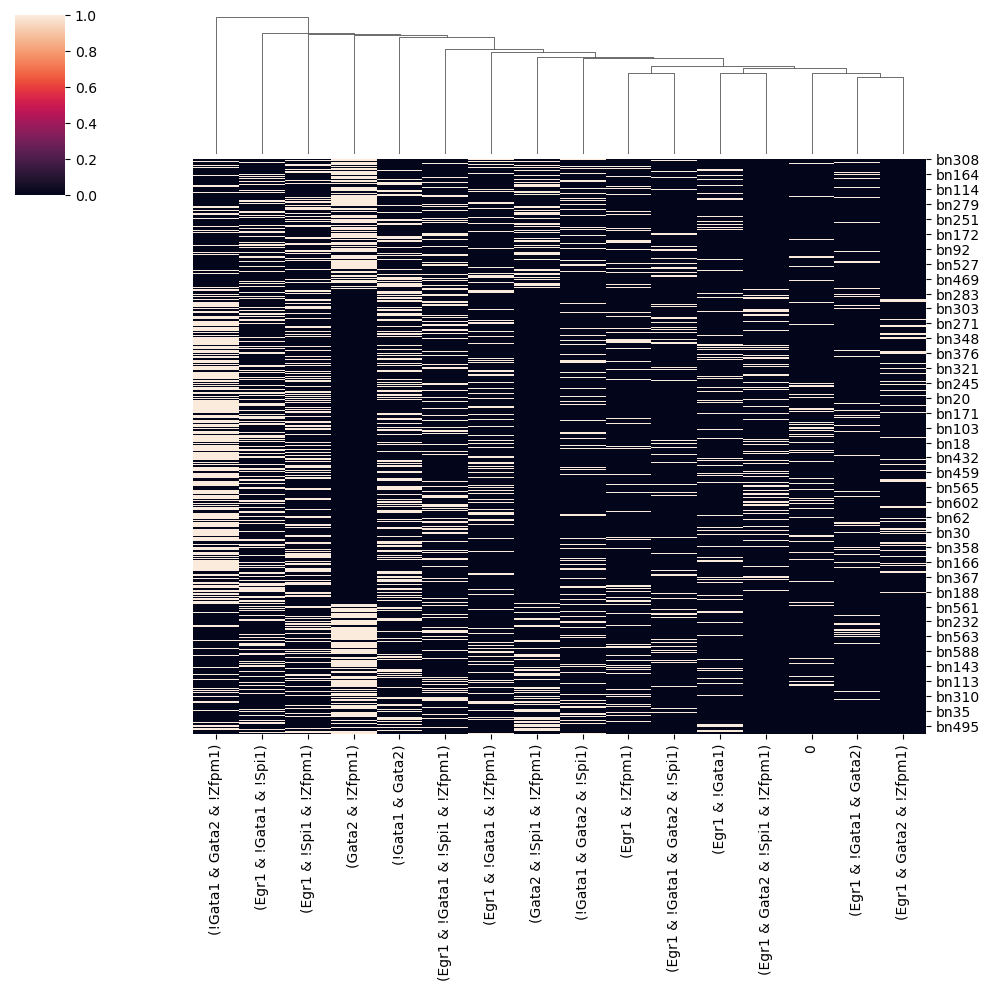

In [198]:
df = split_gene_clauses(model_logic, 'Gata2')
df = df.fillna(0)

from collections import Counter
# Function to count strings in a row
def count_strings_in_row(row):
    return Counter(row)

# Apply the function to each row and convert the result to a DataFrame
row_counts = df.apply(lambda row: pd.Series(count_strings_in_row(row)), 
                            axis=1).fillna(0)
sns.clustermap(row_counts.loc[model_cluster.index], row_cluster=False)

In [68]:
def cluases_logic(model_logic):
    models_clauses = {}
    for i in model_logic.columns:
        # Split each string by the delimiter and create a list of lists
        split_data = [item.split(" | ") for item in model_logic[i]]
        # Create a DataFrame from the list of lists
        df = pd.DataFrame(split_data, index = model_logic[i].index)
        # Save logic clause in dictionary
        

In [31]:
def dnf_mtx(model_path):
    # Load model and change to dnf
    model = mpbn.load(model_path)
    model = model.as_dnf()

    # For loop to create model dnf matrix
    model_mtx = pd.DataFrame()
    for i in list(model.keys()):
        logic = pd.DataFrame(model[i])
        model_mtx = pd.concat([model_mtx, logic], 
                            axis = 0, ignore_index=True)
    # Add nodes index
    #model_mtx.index = list(model.keys())

    return(model_mtx)

In [123]:
(encoded_df.max()+1)/len(encoded_df.index)

Bclaf1       0.001621
CDK46CycD    0.003241
CIPKIP       0.001621
Cebpa        0.001621
Egr1         0.001621
Fli1         0.003241
Gata1        0.003241
Gata2        0.124797
Ikzf1        0.001621
Junb         0.001621
Klf1         0.001621
Myc          0.001621
Spi1         0.001621
Tal1         0.001621
Zfpm1        0.001621
dtype: float64